In [27]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [28]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [29]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   GLDD    1259 non-null   float64
 3   HSON    1259 non-null   float64
 4   ISSC    1259 non-null   float64
 5   KRNT    1259 non-null   float64
 6   RCII    1259 non-null   float64
 7   SAIA    1259 non-null   float64
 8   AMD     1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  APPS    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  AUDC    1259 non-null   float64
 13  DSGX    1259 non-null   float64
 14  TTD     1259 non-null   float64
 15  TSLA    1259 non-null   float64
 16  CHDN    1259 non-null   float64
 17  CLAR    1259 non-null   float64
 18  FIVE    1259 non-null   float64
 19  FOXF    1259 non-null   float64
 20  HTHT    1259 non-null   float64
 21  LULU    1259 non-nu

## Function that saves dataframe to CSV

In [30]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [31]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [32]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [33]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [34]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [35]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [36]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [37]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [38]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [39]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC']

#add in the weightage of stocks
port_shares = [0.01437975,0.104636,0.00768775,0.015512,0.002394,0.015673,0.01420825,0.000511,0.00838005,
               0.0105336,0.0328188,0.0201075,0.01645035,0.001197,0.01551375,0.0425894,0.0113876,0.0300132,
               0.0050862,0.010752,0.0056798,0.0344918,0.0246477,0.00422835,0.0131775,0.0009114,0.00846195,
               0.00270795,0.02266425,0.0236607,0.0045423,0.175]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.348299,5.931584,0.034595,0.220270,0.007164,0.207667,0.149698,0.022944,0.095784,0.670569,...,0.020874,0.003044,0.632192,0.097242,0.055074,0.737031,0.022575,18.117895,39.016453,NaN
2017-01-04,1.355650,5.956191,0.036132,0.228026,0.007226,0.202182,0.151242,0.023021,0.095784,0.677943,...,0.021570,0.003090,0.650047,0.098542,0.054394,0.764241,0.021894,18.143652,39.270981,0.006524
2017-01-05,1.357356,5.885789,0.034364,0.226475,0.007453,0.195912,0.144168,0.022458,0.094192,0.682051,...,0.020874,0.003081,0.644885,0.097026,0.055074,0.783406,0.022439,17.903291,38.957952,-0.007971
2017-01-06,1.372320,5.885106,0.034210,0.223373,0.007411,0.198263,0.138252,0.022934,0.094862,0.704382,...,0.020874,0.003108,0.665532,0.096999,0.055074,0.783169,0.022484,17.772809,38.928463,-0.000757
2017-01-09,1.340686,5.852979,0.033442,0.217168,0.007720,0.209235,0.139024,0.022535,0.096287,0.704066,...,0.020874,0.003199,0.680087,0.096728,0.053714,0.765187,0.023393,17.681817,38.822305,-0.002727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.011237,37.173015,0.121082,0.432009,0.015346,2.403611,0.699046,0.170189,1.293545,7.341919,...,0.398883,0.004922,2.603065,0.617142,1.435780,6.337755,0.100158,66.941393,234.747690,0.022562
2021-12-28,3.037436,37.281732,0.120236,0.437128,0.015800,2.389349,0.695210,0.168727,1.283405,7.186022,...,0.385837,0.005013,2.589780,0.591145,1.376400,6.004376,0.099658,67.180619,233.936447,-0.003456
2021-12-29,3.040443,37.717647,0.120390,0.435267,0.015657,2.419598,0.701319,0.171395,1.242426,7.140096,...,0.399410,0.004867,2.606196,0.597022,1.348296,6.102094,0.097659,67.219039,234.446563,0.002181


## Get old data for portfolio

In [40]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.348299,5.931584,0.034595,0.220270,0.007164,0.207667,0.149698,0.022944,0.095784,0.670569,...,0.020874,0.003044,0.632192,0.097242,0.055074,0.737031,0.022575,18.117895,39.016453,NaN
2017-01-04,1.355650,5.956191,0.036132,0.228026,0.007226,0.202182,0.151242,0.023021,0.095784,0.677943,...,0.021570,0.003090,0.650047,0.098542,0.054394,0.764241,0.021894,18.143652,39.270981,0.006524
2017-01-05,1.357356,5.885789,0.034364,0.226475,0.007453,0.195912,0.144168,0.022458,0.094192,0.682051,...,0.020874,0.003081,0.644885,0.097026,0.055074,0.783406,0.022439,17.903291,38.957952,-0.007971
2017-01-06,1.372320,5.885106,0.034210,0.223373,0.007411,0.198263,0.138252,0.022934,0.094862,0.704382,...,0.020874,0.003108,0.665532,0.096999,0.055074,0.783169,0.022484,17.772809,38.928463,-0.000757
2017-01-09,1.340686,5.852979,0.033442,0.217168,0.007720,0.209235,0.139024,0.022535,0.096287,0.704066,...,0.020874,0.003199,0.680087,0.096728,0.053714,0.765187,0.023393,17.681817,38.822305,-0.002727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.011237,37.173015,0.121082,0.432009,0.015346,2.403611,0.699046,0.170189,1.293545,7.341919,...,0.398883,0.004922,2.603065,0.617142,1.435780,6.337755,0.100158,66.941393,234.747690,0.022562
2021-12-28,3.037436,37.281732,0.120236,0.437128,0.015800,2.389349,0.695210,0.168727,1.283405,7.186022,...,0.385837,0.005013,2.589780,0.591145,1.376400,6.004376,0.099658,67.180619,233.936447,-0.003456
2021-12-29,3.040443,37.717647,0.120390,0.435267,0.015657,2.419598,0.701319,0.171395,1.242426,7.140096,...,0.399410,0.004867,2.606196,0.597022,1.348296,6.102094,0.097659,67.219039,234.446563,0.002181


## Forecasting

In [41]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [42]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [43]:
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.348299,5.931584,0.034595,0.220270,0.007164,0.207667,0.149698,0.022944,0.095784,0.670569,...,0.020874,0.003044,0.632192,0.097242,0.055074,0.737031,0.022575,18.117895,39.016453,NaN
2017-01-04,1.355650,5.956191,0.036132,0.228026,0.007226,0.202182,0.151242,0.023021,0.095784,0.677943,...,0.021570,0.003090,0.650047,0.098542,0.054394,0.764241,0.021894,18.143652,39.270981,0.006524
2017-01-05,1.357356,5.885789,0.034364,0.226475,0.007453,0.195912,0.144168,0.022458,0.094192,0.682051,...,0.020874,0.003081,0.644885,0.097026,0.055074,0.783406,0.022439,17.903291,38.957952,-0.007971
2017-01-06,1.372320,5.885106,0.034210,0.223373,0.007411,0.198263,0.138252,0.022934,0.094862,0.704382,...,0.020874,0.003108,0.665532,0.096999,0.055074,0.783169,0.022484,17.772809,38.928463,-0.000757
2017-01-07,1.372320,5.885106,0.034210,0.223373,0.007411,0.198263,0.138252,0.022934,0.094862,0.704382,...,0.020874,0.003108,0.665532,0.096999,0.055074,0.783169,0.022484,17.772809,38.928463,-0.000757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.011237,37.173015,0.121082,0.432009,0.015346,2.403611,0.699046,0.170189,1.293545,7.341919,...,0.398883,0.004922,2.603065,0.617142,1.435780,6.337755,0.100158,66.941393,234.747690,0.022562
2021-12-28,3.037436,37.281732,0.120236,0.437128,0.015800,2.389349,0.695210,0.168727,1.283405,7.186022,...,0.385837,0.005013,2.589780,0.591145,1.376400,6.004376,0.099658,67.180619,233.936447,-0.003456
2021-12-29,3.040443,37.717647,0.120390,0.435267,0.015657,2.419598,0.701319,0.171395,1.242426,7.140096,...,0.399410,0.004867,2.606196,0.597022,1.348296,6.102094,0.097659,67.219039,234.446563,0.002181


In [44]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [45]:
tot_port_df

,Total
Date,
2017-01-03,39.016453
2017-01-04,39.270981
2017-01-05,38.957952
2017-01-06,38.928463
2017-01-07,38.928463
...,...
2021-12-27,234.747690
2021-12-28,233.936447
2021-12-29,234.446563


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Lags : [1]
Observations : 1824


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


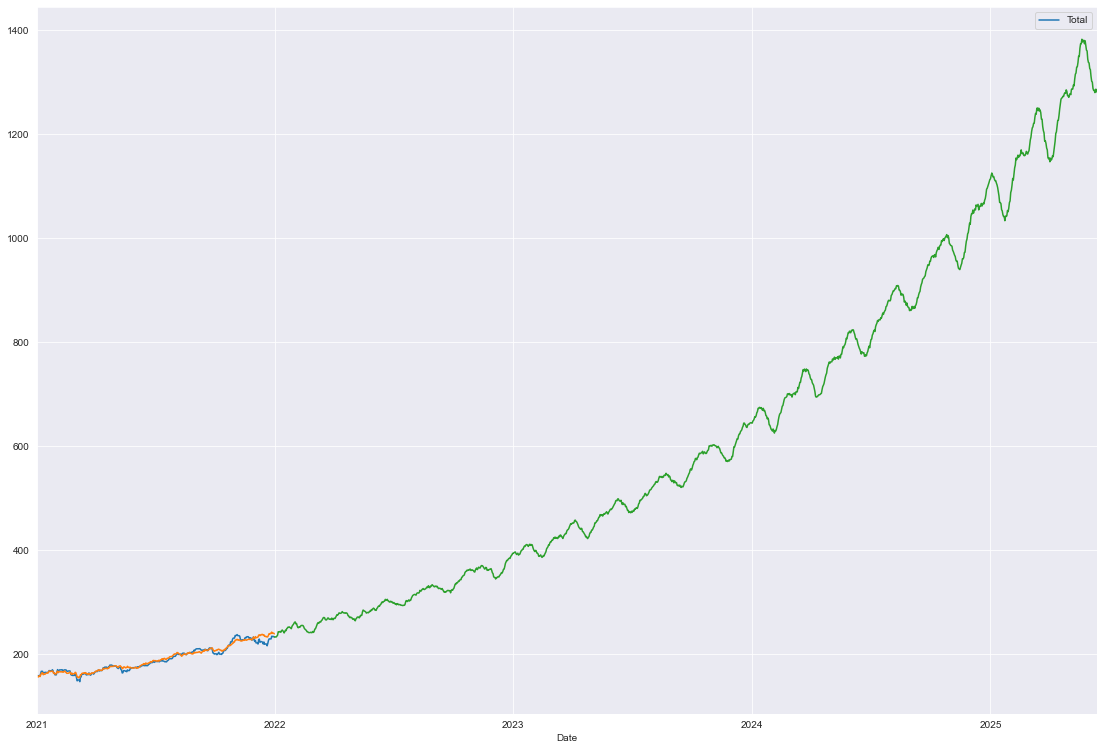

In [46]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [47]:
forecast

2021-12-31     233.140914
2022-01-01     233.572501
2022-01-02     233.199044
2022-01-03     233.419426
2022-01-04     235.318920
                 ...     
2025-06-09    1283.966924
2025-06-10    1279.692924
2025-06-11    1285.995840
2025-06-12    1285.737176
2025-06-13    1280.696636
Freq: D, Length: 1261, dtype: float64

In [48]:
forecast_df = pd.DataFrame(forecast)

In [49]:
forecast_df

,0
2021-12-31,233.140914
2022-01-01,233.572501
2022-01-02,233.199044
2022-01-03,233.419426
2022-01-04,235.318920
...,...
2025-06-09,1283.966924
2025-06-10,1279.692924
2025-06-11,1285.995840
2025-06-12,1285.737176


In [50]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [51]:
return_series

,0
2021-12-31,NaN
2022-01-01,0.001851
2022-01-02,0.000249
2022-01-03,0.001195
2022-01-04,0.009342
...,...
2025-06-09,4.507257
2025-06-10,4.488925
2025-06-11,4.515960
2025-06-12,4.514850


In [52]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  40.593601
